# 1) ¿Por qué el ELE \((S^*, I^*) = (N,0)\) es un “balance”?

Considerando una ciudad sin ninguna persona enferma. En ese caso no hay contagios, así que la única forma en que cambia el número de susceptibles (S) es por nacimientos y muertes "normales".

- **Entran personas (nacimientos)** a ritmo \(\mu N\).  
- **Salen personas (muertes naturales)** de los susceptibles a ritmo \(\mu S\).

Si \(S=N\) y no hay infectados (\(I=0\)), las entradas y salidas son exactamente iguales: lo que nace es equivalente a lo que muere.  
Eso significa que el número de susceptibles no cambia con el tiempo → está en equilibrio.  


---

# 2) Equilibrio endémico: la “tensión” que lo mantiene

Cuando hay enfermedad persistente (\(I^*>0\)), existe una tensión entre dos fuerzas opuestas:

- **Fuerza que empuja hacia arriba**: las nuevas infecciones.  
  Dependen de cuántos susceptibles y cuántos infectados se encuentren (contactos que transmiten la enfermedad).  

- **Fuerza que frena**: la salida de infectados por recuperación o por muerte natural.  

En el equilibrio endémico estas dos fuerzas se igualan:  
las personas que pasan a estar infectadas cada unidad de tiempo son justo las que salen del estado infectado.  

Otra manera de verlo:  
el número efectivo de reproducción (cuántas personas infecta, en promedio, cada infectado dado el número de susceptibles) se ajusta a **1**.  

- Si fuese **mayor que 1**, la infección crecería.  
- Si fuese **menor que 1**, la infección moriría.  
- En el equilibrio endémico está exactamente en **1**, por eso la enfermedad se mantiene estable en la población.

---

# 3) Cómo llevar nacimientos y muertes a un Modelo Basado en Agentes (MBA)

En un MBA se modela a cada persona por separado. Para incluir nacimientos y muertes de forma sencilla:

- **Muerte natural**: en cada paso de tiempo da a cada agente una pequeña probabilidad de morir.  
  Si muere, lo quitas del sistema (sea S, I o R).  

- **Nacimientos**: en cada paso se crea algunos nuevos agentes susceptibles.  
  - Al azar, con una distribución de Poisson con media igual al número esperado de nacimientos.  
  - O bien crear tantos nacimientos como la expectativa de muertes para mantener población estable.  

- **Infección**: para cada susceptible, se calcula la probabilidad de encontrarse con un infectado y con esa probabilidad se marca como nuevo infectado.  

- **Recuperación**: cada infectado tiene una probabilidad por paso de recuperarse.  

**Orden típico de eventos**:  
1. Infecciones  
2. Recuperaciones  
3. Muertes  
4. Nacimientos  

O usar un motor de eventos continuos para manejarlo todo sin sesgos.  

> Esta forma reproduce, a pequeña escala, las tasas del modelo poblacional (\(\mu N, \mu S, ...\)), pero a nivel de individuos.

---

# 4) ¿Se verán iguales las trayectorias \(S\) e \(I\) en el MBA y en las EDO?

No serán idénticas, aunque pueden parecerse “en promedio” si la población es grande y todos se mezclan bien.  

**Diferencias principales:**

- **Aleatoriedad**: en el MBA todo ocurre mediante eventos aleatorios (contagios, muertes, recuperaciones).  
  → Fluctuaciones alrededor de la curva suave del modelo EDO.  

- **Extinción accidental**: en poblaciones finitas, la enfermedad puede desaparecer por azar,  
  aun cuando las EDO predicen que debería quedarse.  

- **Estructura de contactos**: si se modela quién se relaciona con quién (redes, grupos),  
  la dinámica cambia respecto a la mezcla homogénea de las EDO → brotes locales, retrasos, patrones distintos.  

- **Heterogeneidad**: variaciones entre individuos (algunos contagian más, otros se recuperan más rápido)  
  generan trayectorias que la EDO promedio no captura.  

---

# Referencias
Delamater, P. L., Street, E. J., Leslie, T. F., Yang, Y. T., & Jacobsen, K. H. (2019). Complexity of the basic reproduction number (R0). Emerging Infectious Diseases, 25(1), 1–4. https://stacks.cdc.gov/view/cdc/80426/cdc_80426_DS1.pdf
 

Hethcote, H. W. (2000). The mathematics of infectious diseases. SIAM Review, 42(4), 599–653. https://epubs.siam.org/doi/10.1137/S0036144500371907
 

Keeling, M. J., & Rohani, P. (2008). Modeling infectious diseases in humans and animals (Cap. 1). Princeton University Press. https://math.uchicago.edu/~shmuel/Modeling/Keeling%20and%20Rohani/chap%201.pdf
 


## **Práctica Parte 1**

R0 = 4.1667 (debería ser > 1)
ELE: S=1000.000000, I=0.000000
Endémico: S*=240.000000, I*=126.666667


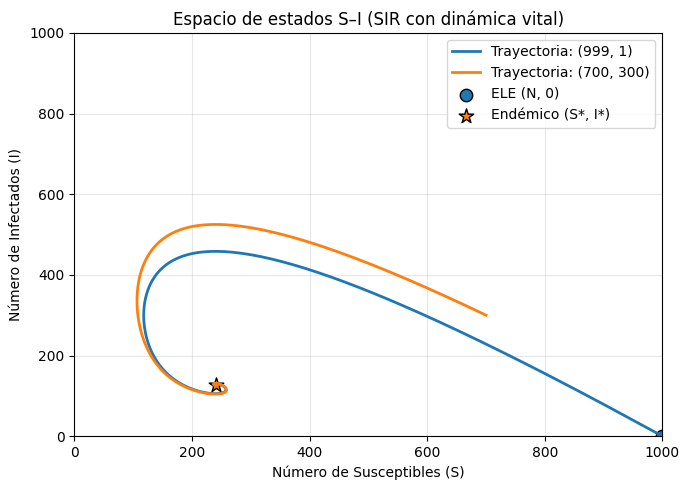

In [2]:
# ============================================
# Parte 1 — Simulación SIR con dinámica vital (fase S–I)
# ============================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def sir_vital(t, y, beta, gamma, mu, N):
    S, I = y
    dS = mu*N - (beta*S*I)/N - mu*S
    dI = (beta*S*I)/N - (gamma + mu)*I
    return [dS, dI]

# 2) Parámetros (R0 > 1 por construcción)
N = 1000
beta = 0.5       # <-- CORREGIDO: ya NO dividir entre N
gamma = 0.1
mu = 0.02

R0 = beta / (gamma + mu)
print(f"R0 = {R0:.4f} (debería ser > 1)")
assert R0 > 1, "R0 debe ser > 1 para que exista equilibrio endémico positivo."

# 3) Condiciones iniciales y simulación (0..300 días)
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 3001)

y0_a = [999, 1]      # Inicio de brote
y0_b = [700, 300]    # Epidemia mayor

sol_a = solve_ivp(sir_vital, t_span, y0_a, t_eval=t_eval,
                  args=(beta, gamma, mu, N), rtol=1e-8, atol=1e-10)
sol_b = solve_ivp(sir_vital, t_span, y0_b, t_eval=t_eval,
                  args=(beta, gamma, mu, N), rtol=1e-8, atol=1e-10)

S_a, I_a = sol_a.y
S_b, I_b = sol_b.y

# 4) Equilibrios
S_ele, I_ele = N, 0.0
S_star = N * (gamma + mu) / beta
I_star = N * mu * (beta - gamma - mu) / (beta * (gamma + mu))
S_star = np.clip(S_star, 0.0, N)
I_star = np.clip(I_star, 0.0, N - S_star)

print(f"ELE: S={S_ele:.6f}, I={I_ele:.6f}")
print(f"Endémico: S*={S_star:.6f}, I*={I_star:.6f}")

# 5) Gráfico de fase
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(S_a, I_a, lw=2, label="Trayectoria: (999, 1)")
ax.plot(S_b, I_b, lw=2, label="Trayectoria: (700, 300)")
ax.scatter([S_ele], [I_ele], s=80, marker='o', edgecolor='k', label="ELE (N, 0)")
ax.scatter([S_star], [I_star], s=120, marker='*', edgecolor='k', label="Endémico (S*, I*)")

ax.set_xlabel("Número de Susceptibles (S)")
ax.set_ylabel("Número de Infectados (I)")
ax.set_title("Espacio de estados S–I (SIR con dinámica vital)")
ax.set_xlim(0, N)
ax.set_ylim(0, N)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
